In [19]:
from collections import namedtuple
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import (
    explained_variance_score,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller


def return_regr_score(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    evs = explained_variance_score(y_true, y_pred)
    Scores = namedtuple("Scores", ["mse", "mae", "rmse", "r2", "evs"])
    return Scores(mse, mae, rmse, r2, evs)


# Function to generate and plot time series, ACF, and PACF
def plot_series_with_acf_pacf(series, title):
    fig, axes = plt.subplots(1, 3, figsize=(15, 3))

    axes[0].plot(series, label="Time Series")
    axes[0].set_title(f"{title} - Time Series")
    # axes[0].legend()
    plot_acf(series, lags=20, ax=axes[1], title="ACF")
    plot_pacf(series, lags=20, ax=axes[2], title="PACF")
    plt.tight_layout()
    plt.show()


def sarima_forecast(train_series, predicted_series, p, d, q, P, D, Q, s):
    """
    Forecasts a time series one timestep at a time using an ARIMA model.

    Parameters:
        train_series (pd.Series or np.array): The time series data for training.
        predicted_series (pd.Series or np.array): The actual series to compare the predictions.
        p (int): The order of the AR component.
        d (int): The order of differencing.
        q (int): The order of the MA component.

    Returns:
        np.array: The forecasted values.
    """
    train_series = np.array(train_series).copy()
    predicted_series = np.array(predicted_series).copy()
    steps = len(predicted_series)
    prediction = np.zeros(steps)

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore") # ! to ignore "Using zeros as starting parameters" warning
        # Forecast one timestep at a time
        for step in range(steps):
            # Fit the ARIMA model to the current data
            model = ARIMA(train_series, order=(p, d, q), seasonal_order=(P, D, Q, s))
            model_fitted = model.fit()

            # Predict the next value and store it in prediction
            predicted_next_value = model_fitted.forecast(steps=1)
            prediction[step] = predicted_next_value[0]

            # Append the actual value to the train_series
            actual_next_value = np.array([predicted_series[step]])
            train_series = np.concatenate((train_series, actual_next_value))

    # Return only the forecasted values
    return prediction


def find_d(series):
    d = 0
    while True:
        result = adfuller(series)
        if result[1] < 0.05:  # Stationary (reject null hypothesis)
            break
        series = np.diff(series)
        d += 1
    return d


def optimize_sarima(endog: pd.Series, 
    ps: list, qs: list, d: int,
    Ps: list, Qs: list, D: int, s: int):
    """
    Optimize SARIMA hyperparameters by trying all possible combinations.
    credit to Marco Peixeiro

    Args:
        endog (pd.Series)
        ps (list): list of p to try
        qs (list): list of q to try
        d (int): d
        Ps (list): list of P to try
        Qs (list): list of Q to try
        D (int): D
        s (int): s

    Returns:
        pd.DataFrame: dataframe with all combinations and their AIC
    """
    import warnings
    from itertools import product
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    from tqdm import tqdm

    order_list= list(product(
        ps, [d], qs, 
        Ps, [D], Qs, [s])) # get all possible combinations of (p, d, q, P, D, Q, s)

    results= []
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore") # ! to ignore "Using zeros as starting parameters" warning
        for order in tqdm(order_list):
            model= (SARIMAX(
                endog= endog, 
                simple_differencing= False, 
                order= (order[0], order[1], order[2]), 
                seasonal_order= (order[3], order[4], order[5], order[6]) 
            ))
            result= model.fit(disp= False)
            aic= result.aic
            results.append((order, aic))

    df_results= pd.DataFrame(results, columns= ['(p, d, q, P, D, Q, s)', 'aic']).sort_values('aic', ascending= True)
    return df_results

# Load Data

In [2]:
path = "input/delhi-climate/DailyDelhiClimateTrain.csv"
df = pd.read_csv(path)
print(df.shape)
df.head() 

(1462, 5)


,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [3]:
x = df.set_index(pd.to_datetime(df["date"]))["meantemp"].to_frame()
x_bounded = x.loc[x.index < "2013-04-01"]

n_train = round(x_bounded.shape[0] * 0.87)
x_train = x_bounded[:n_train].values.flatten()
x_test = x_bounded[n_train:].values.flatten()

print(x_train.shape, x_test.shape)

(78,) (12,)


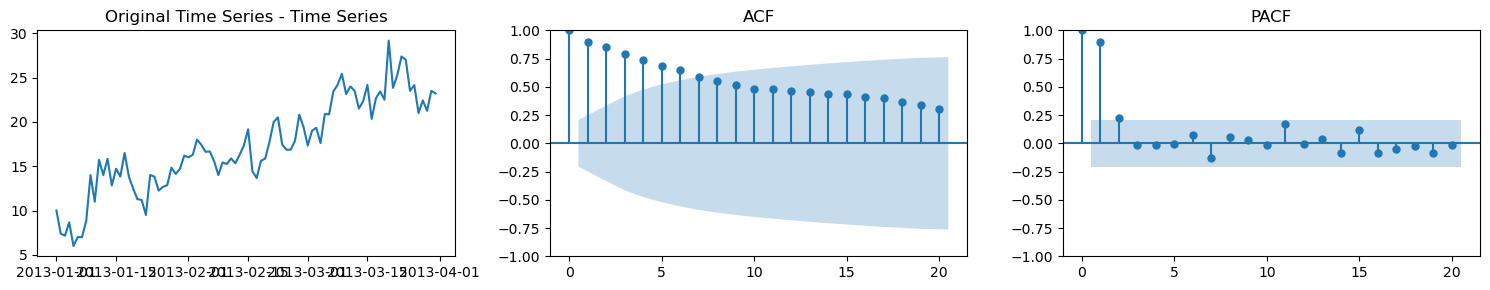

In [4]:
plot_series_with_acf_pacf(x_bounded, "Original Time Series")

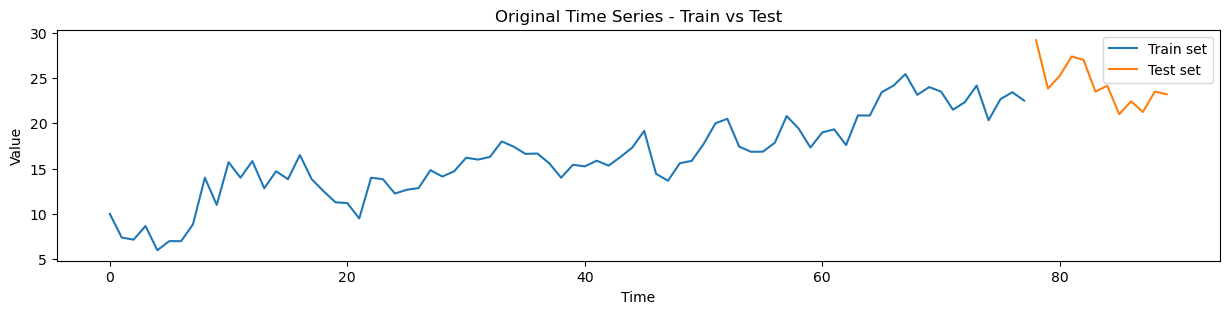

In [5]:
ax = plt.figure(figsize=(15, 3))
plt.plot(range(0, n_train), x_train, label="Train set")
plt.plot(range(n_train, n_train + len(x_test)), x_test, label="Test set")
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Original Time Series - Train vs Test")
plt.legend()
plt.show()

### Step 1: Select d by using ADF test

In [6]:
d = find_d(x_train)

print(f"Optimal differencing order: d = {d}")

Optimal differencing order: d = 1


In [7]:
x_train_diff_1 = np.diff(x_train)
x_test_diff_1 = np.diff(x_test)

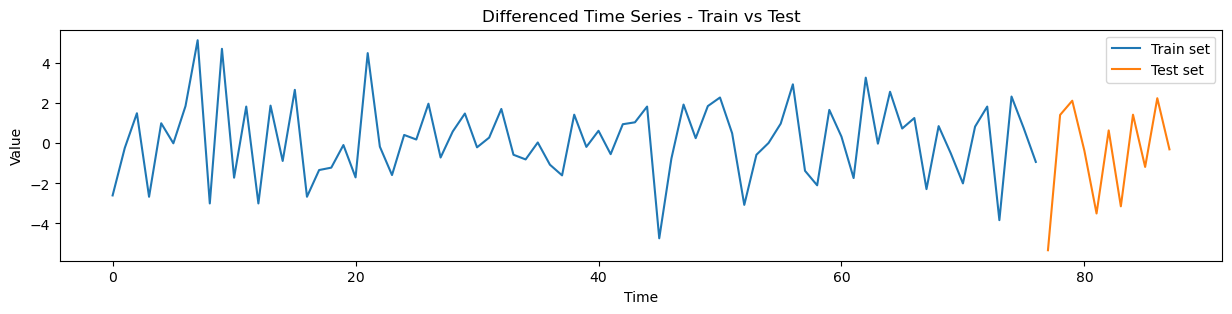

In [8]:
ax = plt.figure(figsize=(15, 3))
plt.plot(range(0, n_train - 1), x_train_diff_1, label="Train set")
plt.plot(
    range(n_train - 1, n_train - 1 + len(x_test_diff_1)),
    x_test_diff_1,
    label="Test set",
)
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Differenced Time Series - Train vs Test")
plt.legend()
plt.show()

### Step 2: Select model and order by using AIC

In [15]:
# Define the range of parameters to test
p_values = range(0, 3)  # AR terms
d_values = 1  # Differencing
q_values = range(0, 3)  # MA terms

# Iterate through all combinations of p, d, q
optimize_sarima(
    endog=x_train, 
    ps = list(p_values),
    d = d,
    qs = list(q_values),
    Ps = list(p_values),
    D = d,
    Qs = list(q_values),
    s = 7
)

100%|██████████| 81/81 [00:40<00:00,  2.00it/s]


,"(p, d, q, P, D, Q, s)",aic
17,"(0, 1, 1, 2, 1, 2, 7)",300.830460
35,"(1, 1, 0, 2, 1, 2, 7)",301.549757
11,"(0, 1, 1, 0, 1, 2, 7)",302.278545
16,"(0, 1, 1, 2, 1, 1, 7)",302.297070
34,"(1, 1, 0, 2, 1, 1, 7)",302.511347
...,...,...
36,"(1, 1, 1, 0, 1, 0, 7)",337.560927
54,"(2, 1, 0, 0, 1, 0, 7)",337.589204
18,"(0, 1, 2, 0, 1, 0, 7)",337.917201
9,"(0, 1, 1, 0, 1, 0, 7)",338.492849


### Step 3: Test and validate the model

In [20]:
forecast = sarima_forecast(
    train_series=x_train, 
    predicted_series=x_test, 
    p=0, d=1, q=1, P=2, D=1, Q=2, s=7
)

score = return_regr_score(x_test, forecast)

print("SARIMA model:", score)

SARIMA model: Scores(mse=7.055264333229417, mae=2.357333973189035, rmse=2.656174755777454, r2=-0.24946375196934367, evs=-0.24241612032187)


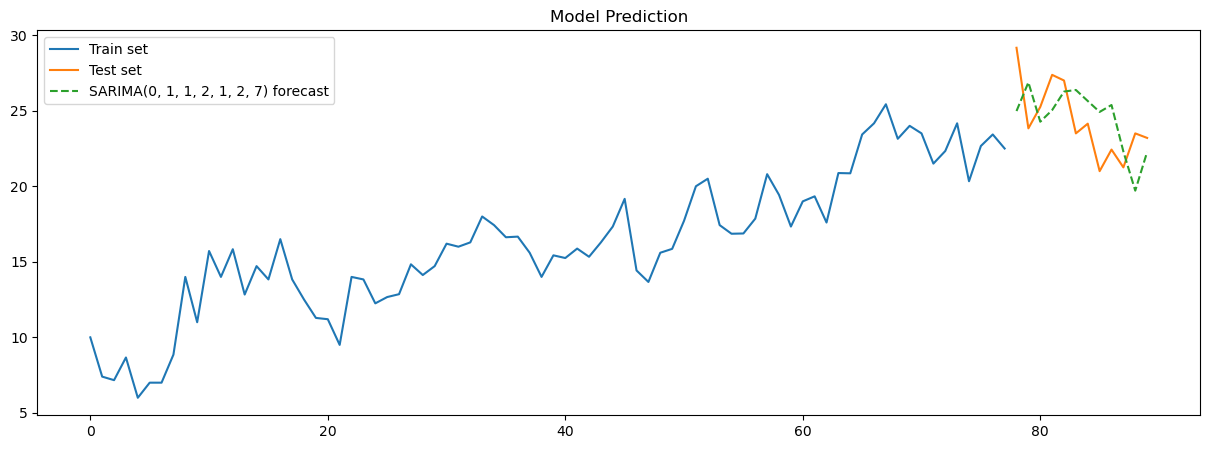

In [21]:
ax = plt.figure(figsize=(15, 5))
plt.plot(range(0, len(x_train)), x_train, label="Train set")
plt.plot(
    range(len(x_train), len(x_train) + len(x_test)),
    x_test,
    label="Test set",
)
plt.plot(
    range(len(x_train), len(x_train) + len(x_test)),
    forecast,
    label="SARIMA(0, 1, 1, 2, 1, 2, 7) forecast",
    linestyle="--",
)
plt.title("Model Prediction")
plt.legend()
plt.show()